In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

## Load Data

In [2]:
data = pd.read_csv('https://www.dropbox.com/s/x7p6qmenhlg63pq/national_history.csv?dl=1', \
                 thousands = ',', infer_datetime_format = True)

In [3]:
data.head(5)

Date  State (or territory)  New tests  \
0  10/19/2020                    56    1200056   
1  10/18/2020                    56     978769   
2  10/17/2020                    56    1188950   
3  10/16/2020                    56    1141550   
4  10/15/2020                    56    1021863   

   Cases (confirmed plus probable)  Negative PCR tests (people)  \
0                          8171703                    109195067   
1                          8114555                    108172840   
2                          8065633                    107406051   
3                          8007690                    106457881   
4                          7939566                    105479593   

   Cumulative hospitalized/Ever hospitalized  \
0                                   436817.0   
1                                   435133.0   
2                                   434280.0   
3                                   432745.0   
4                                   430887.0   

   Currently hospitalized/Now hospitalized  Deaths (confirmed and probable)  \
0                                  37744.0                         211846.0   
1                                  36415.0                         211390.0   
2                                  37392.0                         210997.0   
3                                  37336.0                         210217.0   
4                                  37308.0                         209340.0   

   Recovered  Total test results  
0  3272603.0           126033173  
1  3234183.0           124833117  
2  3220607.0           123854348  
3  3197539.0           122665398  
4  3177397.0           121523848

In [4]:
data.shape
print(f"Data shape: {data.shape[0]} rows x {data.shape[1]} cols")

Data shape: 272 rows x 10 cols


In [5]:
data.dtypes

Date                                          object
State (or territory)                           int64
New tests                                      int64
Cases (confirmed plus probable)                int64
Negative PCR tests (people)                    int64
Cumulative hospitalized/Ever hospitalized    float64
Currently hospitalized/Now hospitalized      float64
Deaths (confirmed and probable)              float64
Recovered                                    float64
Total test results                             int64
dtype: object

## Quick Features Overview

-`Date`: date                         
-`State (or territory)`:state                       
-`New tests`: Daily increase in `Total test results`               
-`Cases (confirmed plus probable)`: Cumulative total number of confirmed plus probable cases of COVID-19 <br />
-`Negative PCR tests (people)`: Cumulative total number of unique people with a completed PCR test that returns negative <br /> 
-`Cumulative hospitalized/Ever hospitalized`: Cumulative total number of individuals who have ever been hospitalized       
-`Currently hospitalized/Now hospitalized`: Number of individuals who are currently hospitalized with COVID-19         
-`Deaths (confirmed and probable)`: Cumulative total fatalities with confirmed OR probable COVID-19 case diagnosis         
-`Recovered `: Cumulative total number of people that are identified as recovered from COVID-19                          
-`Total test results`: Cumulative total of people who were tested      


In [6]:
data.columns

Index(['Date', 'State (or territory)', 'New tests',
       'Cases (confirmed plus probable)', 'Negative PCR tests (people)',
       'Cumulative hospitalized/Ever hospitalized',
       'Currently hospitalized/Now hospitalized',
       'Deaths (confirmed and probable)', 'Recovered', 'Total test results'],
      dtype='object')

The existing column names are too long. Let's replace them with shortened names.

In [7]:
#Let's rename the column 

new_col_names ={
    'Date':'date', 
    'State (or territory)':'state', 
    'New tests':'dailyTest',
    'Cases (confirmed plus probable)': 'cumPosResult', 
    'Negative PCR tests (people)':'cumNegResult',
    'Cumulative hospitalized/Ever hospitalized':'cumHospital',
    'Currently hospitalized/Now hospitalized':'curtHospital',
    'Deaths (confirmed and probable)':'cumDeath', 
    'Recovered':'cumRecover', 
    'Total test results':'totTestResult'
   
}

data.rename(columns = new_col_names, inplace = True)

**Data Period**

In [8]:
data['date'] = pd.to_datetime(data['date']).dt.date
print(f"First Date:{data['date'].min()}\n Last Date:{data['date'].max()}")

First Date:2020-01-22
 Last Date:2020-10-19


**Check data missingness**

In [9]:
data.isna().sum(axis=0)

date              0
state             0
dailyTest         0
cumPosResult      0
cumNegResult      0
cumHospital      42
curtHospital     55
cumDeath         19
cumRecover       63
totTestResult     0
dtype: int64

In [10]:
data[data.isna().any(axis=1)]

date  state  dailyTest  cumPosResult  cumNegResult  cumHospital  \
209  2020-03-24     56      71336         62371        321763       5117.0   
210  2020-03-23     56      59689         51602        263068       3937.0   
211  2020-03-22     56      49032         40163        216174       3023.0   
212  2020-03-21     56      50660         31038        179718       2020.0   
213  2020-03-20     56      41977         24245        141090        108.0   
..          ...    ...        ...           ...           ...          ...   
267  2020-01-26      2          0             0             0          NaN   
268  2020-01-25      2          0             0             0          NaN   
269  2020-01-24      2          0             0             0          NaN   
270  2020-01-23      2          1             0             0          NaN   
271  2020-01-22      2          0             0             0          NaN   

     curtHospital  cumDeath  cumRecover  totTestResult  
209        3902.0     815.0         NaN         424271  
210        2770.0     581.0         NaN         352935  
211        2155.0     480.0         NaN         293246  
212        1436.0     334.0         NaN         244214  
213        1042.0     272.0         NaN         193554  
..            ...       ...         ...            ...  
267           NaN       NaN         NaN              2  
268           NaN       NaN         NaN              2  
269           NaN       NaN         NaN              2  
270           NaN       NaN         NaN              2  
271           NaN       NaN         NaN              1  

[63 rows x 10 columns]

We can see that the missing values are only shown in the early dates of the dateset, and `nan` can be replaced with `0`.

In [11]:
data.fillna(0, inplace = True)

### Key Observation

- Most of the features are 'cumulative values', but we need also 'daily statistics'.

In [12]:
def insert_daily_cols(cum_col_list):
    for col in cum_cols:
        day_col = col.replace('cum', 'daily')
        data[day_col]= data[col].sub(data[col].shift()).abs().shift(-1)

        
cum_cols = ['cumPosResult', 'cumNegResult', 'cumDeath', 'cumRecover']
insert_daily_cols(cum_cols)

Let's select daily statistics from the dataset

In [13]:
df = data[['date', 'dailyPosResult', 'cumHospital','curtHospital', 'dailyNegResult', 'dailyRecover', 'dailyDeath']]    
df = df.set_index(['date'])

Fill the last rows

In [14]:
df.fillna(0, inplace = True)

## Exploratory Data Analysis (EDA)

In [15]:
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [16]:
df.sort_index(inplace = True)

### Plots of daily positive test results and fatalities

**7 Days Rolling Mean & Standard Deviation - Daily Positive Result**

In [17]:
df['weekly_mean_posResult'] = df['dailyPosResult'].rolling(7).mean()
df.fillna(0, inplace = True)

In [18]:
#Daily positive test restults
rolmean = df['dailyPosResult'].rolling(7).mean()
rolstd = df['dailyPosResult'].rolling(7).std()


df_daily = df.groupby(df.index)['dailyPosResult'].sum().sort_values().reset_index()

fig = px.bar(df_daily.sort_values('dailyPosResult',ascending = False), 
             x='date', y='dailyPosResult',  labels={'date':'Date', 'dailyPosResult': 'Daily Cases'})
fig.update_layout(title_text='Daily Positive COVID-19 Test Results in US')

fig.add_trace(go.Scatter(x=df.index, y=rolmean, line=dict(color='red'), name='Rolling Mean'),
              )

fig.add_trace(go.Scatter(x=df.index, y=rolstd, line=dict(color='black'), name='Rolling STD'),
              )


fig.show()

**7 Days Rolling Mean & Standard Deviation - Daily Fatalities**

In [19]:
#Daily fatality restults
rolmean_fatal = df['dailyDeath'].rolling(7).mean()
rolstd_fatal = df['dailyDeath'].rolling(7).std()


df_daily = df.groupby(df.index)['dailyDeath'].sum().sort_values().reset_index()

fig = px.bar(df_daily.sort_values('dailyDeath',ascending = False), 
             x='date', y='dailyDeath', color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Daily Fatalities with COVID-19 in US')

fig.add_trace(go.Scatter(x=df.index, y=rolmean_fatal, line=dict(color='red'), name='Rolling Mean'),
              )

fig.add_trace(go.Scatter(x=df.index, y=rolstd_fatal, line=dict(color='black'), name='Rolling STD'))

fig.show()

## Perform Data Stationary Test

In [20]:
df_copy = df[['dailyDeath']].copy(deep=True)

In [21]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings 
warnings.filterwarnings('ignore')

Split train and test dataset: Let's validate the trained model with the last 10 days observations (10/10/20 - 10/19/20)

In [22]:
# Train model with 90% of data to increase the accuracy
# 0.9 * 272
train_size = 244
train_df, test_df = df_copy[0:train_size], df_copy[train_size:]

Next, let's check whether the data (e.g., Daily Fatalities) is sationary

In [23]:
#Perform Dickey-Fuller test

def check_stationary(ts):
    print('Results of Dickey-Fuller Test:')
    stationary_test = adfuller(ts, autolag='AIC')
    results = pd.Series(stationary_test[0:4], 
                        index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,val in stationary_test[4].items():
        results['Critical Value (%s)'%key] = val
    print (results)

In [24]:
def plot_stationary(ts):
    rolmean = ts.rolling(7).mean()
    rolstd = ts.rolling(7).std()
    fig = plt.figure(figsize=(10, 8))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

In [25]:
check_stationary(train_df)

Results of Dickey-Fuller Test:
Test Statistic                  -2.571657
p-value                          0.098998
#Lags Used                      14.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


In [43]:
train_first_diff = train_df - train_df.shift(1)
train_first_diff = train_first_diff.dropna(inplace = False)
print(check_stationary(train_first_diff))

Results of Dickey-Fuller Test:
Test Statistic                  -2.649551
p-value                          0.083182
#Lags Used                      13.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64
None


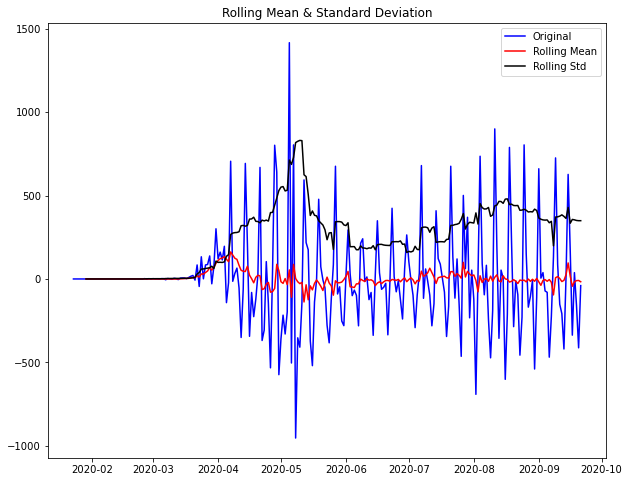

In [27]:
plot_stationary(train_first_diff)

p-value is too high to make the time series into stationary data. Let's dive into other method

## Build the Model 

The ‘auto_arima’ function from the ‘pmdarima’ library will be used to identify the most optimal parameters for an ARIMA model and returns a fitted ARIMA model.

In [28]:
from pmdarima import auto_arima 

Fit auto_arima function to daily fatalities 

### Scenario 1 - (train:test = 90:10)

In [29]:
stepwise_fit = auto_arima(train_df, 
                          start_p = 1, 
                          start_q = 1, 
                          max_p = 10, 
                          max_q = 7, 
                          m = 12, 
                          start_P = 0, 
                          seasonal = True, 
                          d = 1, 
                          D = 1, 
                          trace = True, 
                          random = True,
                          error_action ='ignore',   
                          suppress_warnings = True,   
                          stepwise = True)            
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3505.076, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3426.166, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3506.381, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3358.546, Time=0.33 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3356.764, Time=0.23 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3428.896, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3358.304, Time=0.33 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=3338.423, Time=0.89 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  244
Model:             SARIMAX(8, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1578.454
Date:                             Fri, 15 Jan 2021   AIC                           3180.909
Time:                                     00:42:03   BIC                           3222.218
Sample:                                          0   HQIC                          3197.570
                                             - 244                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0688      0.137     -0.503      0.615      -0.337       0.199
ar.L2         -0.1774      0.057     -3.118      0.002      -0.289      -0.066
ar.L3         -0.1197      0.048     -2.508      0.012      -0.213      -0.026
ar.L4         -0.0759      0.058     -1.304      0.192      -0.190       0.038
ar.L5         -0.1237      0.052     -2.384      0.017      -0.225      -0.022
ar.L6          0.0937      0.054      1.732      0.083      -0.012       0.200
ar.L7          0.5353      0.047     11.508      0.000       0.444       0.626
ar.L8          0.2225      0.098      2.278      0.023       0.031       0.414
ma.L1         -0.3853      0.144     -2.680      0.007      -0.667      -0.104
ar.S.L12      -0.7379      0.069    -10.718      0.000      -0.873      -0.603
ar.S.L24      -0.2809      0.066     -4.250      0.000      -0.410      -0.151
sigma2      4.753e+04   3571.205     13.309      0.000    4.05e+04    5.45e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                52.62
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# Fit a SARIMAX(8, 1, 1)x(0, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model1 = SARIMAX(train_df,  
                order = (8, 1, 1),  
                seasonal_order =(0, 1, 1, 12)) 
  
result1 = model1.fit() 
result1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         dailyDeath   No. Observations:                  244
Model:             SARIMAX(8, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1560.478
Date:                            Fri, 15 Jan 2021   AIC                           3142.956
Time:                                    00:42:04   BIC                           3180.823
Sample:                                01-22-2020   HQIC                          3158.229
                                     - 09-21-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1010      0.107      0.948      0.343      -0.108       0.310
ar.L2         -0.0636      0.053     -1.193      0.233      -0.168       0.041
ar.L3         -0.0377      0.053     -0.707      0.479      -0.142       0.067
ar.L4          0.0351      0.067      0.528      0.598      -0.095       0.166
ar.L5         -0.1064      0.061     -1.752      0.080      -0.225       0.013
ar.L6          0.2350      0.056      4.200      0.000       0.125       0.345
ar.L7          0.5798      0.051     11.449      0.000       0.481       0.679
ar.L8          0.1822      0.095      1.926      0.054      -0.003       0.368
ma.L1         -0.5645      0.101     -5.600      0.000      -0.762      -0.367
ma.S.L12      -0.9296      0.145     -6.420      0.000      -1.213      -0.646
sigma2      3.939e+04   4834.626      8.148      0.000    2.99e+04    4.89e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               139.83
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

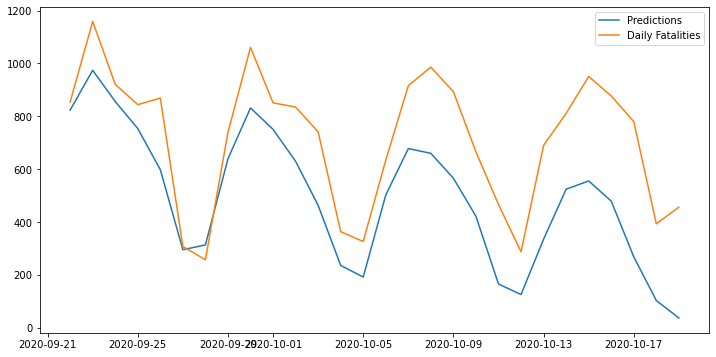

In [50]:
start = "2020-09-22"
end = "2020-10-19"

predictions1 = result1.predict(start, end, typ = 'levels').rename("Predictions")


fig = plt.figure(figsize=(12, 6))
orig = plt.plot(predictions1, label='Predictions')
mean = plt.plot(test_df['dailyDeath'], label='Daily Fatalities')
plt.legend(loc='best')
plt.title('')
plt.show()

In [51]:
predictions1

2020-09-22    823.493185
2020-09-23    974.264104
2020-09-24    855.960560
2020-09-25    753.548693
2020-09-26    597.770305
2020-09-27    294.831440
2020-09-28    313.010371
2020-09-29    639.032551
2020-09-30    831.685655
2020-10-01    750.577516
2020-10-02    629.617965
2020-10-03    462.808278
2020-10-04    235.455256
2020-10-05    191.410035
2020-10-06    501.829090
2020-10-07    677.630959
2020-10-08    659.824321
2020-10-09    565.450758
2020-10-10    421.397868
2020-10-11    164.974831
2020-10-12    125.128380
2020-10-13    334.798641
2020-10-14    523.913874
2020-10-15    555.194922
2020-10-16    478.896117
2020-10-17    267.829917
2020-10-18    102.370102
2020-10-19     36.416683
Freq: D, Name: Predictions, dtype: float64

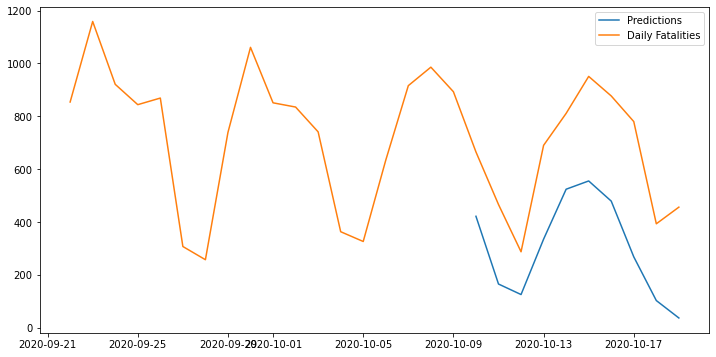

In [48]:
start = "2020-10-10"
end = "2020-10-19"

predictions2 = result1.predict(start, end, typ = 'levels').rename("Predictions")


fig = plt.figure(figsize=(12, 6))
orig = plt.plot(predictions2, label='Predictions')
mean = plt.plot(test_df['dailyDeath'], label='Daily Fatalities')
plt.legend(loc='best')
plt.title('')
plt.show()

### Scenario 2 - (train:test = 95:5)

In [34]:
train_size = 262
train_df1, test_df1 = df_copy[0:train_size], df_copy[train_size:]

In [35]:
stepwise_fit = auto_arima(train_df1, 
                          start_p = 1, 
                          start_q = 1, 
                          max_p = 10, 
                          max_q = 7, 
                          m = 12, 
                          start_P = 0, 
                          seasonal = True, 
                          d = 1, 
                          D = 1, 
                          trace = True, 
                          random = True,
                          error_action ='ignore',   
                          suppress_warnings = True,   
                          stepwise = True)            
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3780.386, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3696.296, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3781.518, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3619.987, Time=0.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3618.082, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3700.438, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3619.850, Time=0.34 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=3596.358, Time=0.80 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3691.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  262
Model:             SARIMAX(7, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1698.005
Date:                             Fri, 15 Jan 2021   AIC                           3418.010
Time:                                     00:46:57   BIC                           3456.702
Sample:                                          0   HQIC                          3433.584
                                             - 262                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2239      0.063      3.554      0.000       0.100       0.347
ar.L2         -0.1229      0.040     -3.059      0.002      -0.202      -0.044
ar.L3         -0.0659      0.046     -1.447      0.148      -0.155       0.023
ar.L4         -0.0464      0.056     -0.824      0.410      -0.157       0.064
ar.L5         -0.0867      0.052     -1.671      0.095      -0.188       0.015
ar.L6          0.1473      0.053      2.784      0.005       0.044       0.251
ar.L7          0.5763      0.045     12.702      0.000       0.487       0.665
ma.L1         -0.6134      0.074     -8.313      0.000      -0.758      -0.469
ar.S.L12      -0.7205      0.065    -11.163      0.000      -0.847      -0.594
ar.S.L24      -0.2983      0.062     -4.795      0.000      -0.420      -0.176
sigma2       4.79e+04   3435.910     13.940      0.000    4.12e+04    5.46e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                87.91
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             0.28
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Fit a SARIMAX(7, 1, 2)x(1, 1, 1, 12) on the training set 

from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model2 = SARIMAX(train_df1,  
                order = (7, 1, 2),  
                seasonal_order =(1, 1, 1, 12)) 
  
result2 = model2.fit() 
result2.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           dailyDeath   No. Observations:                  262
Model:             SARIMAX(7, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1685.286
Date:                              Fri, 15 Jan 2021   AIC                           3394.573
Time:                                      00:48:02   BIC                           3436.782
Sample:                                  01-22-2020   HQIC                          3411.563
                                       - 10-09-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4606      0.108      4.274      0.000       0.249       0.672
ar.L2         -0.4736      0.096     -4.927      0.000      -0.662      -0.285
ar.L3         -0.0199      0.079     -0.250      0.803      -0.176       0.136
ar.L4         -0.0277      0.115     -0.241      0.809      -0.253       0.198
ar.L5         -0.2630      0.095     -2.777      0.005      -0.449      -0.077
ar.L6          0.1431      0.088      1.627      0.104      -0.029       0.315
ar.L7          0.3982      0.085      4.660      0.000       0.231       0.566
ma.L1         -0.8821      0.107     -8.258      0.000      -1.092      -0.673
ma.L2          0.4537      0.092      4.934      0.000       0.273       0.634
ar.S.L12      -0.0359      0.142     -0.253      0.800      -0.314       0.243
ma.S.L12      -0.8849      0.161     -5.500      0.000      -1.200      -0.570
sigma2      5.279e+04   5743.960      9.191      0.000    4.15e+04     6.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):               174.25
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             0.38
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

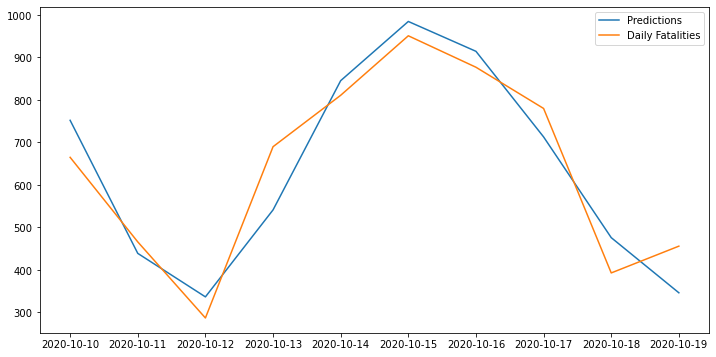

In [37]:
start = "2020-10-10"
end = "2020-10-19"

predictions2 = result2.predict(start, end, typ = 'levels').rename("Predictions")


fig = plt.figure(figsize=(12, 6))
orig = plt.plot(predictions2, label='Predictions')
mean = plt.plot(test_df1['dailyDeath'], label='Daily Fatalities')
plt.legend(loc='best')
plt.title('')
plt.show()

Validation result shown in the figure above looks good! Next, estimate MAPE of the model

In [52]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [53]:
acc1 = mape(test_df['dailyDeath'], predictions1)
print("Mean Absolute Percent Error: {:.2f}%".format(acc1))

Mean Absolute Percent Error: 34.27%


In [54]:
acc2 = mape(test_df1['dailyDeath'], predictions2)
print("Mean Absolute Percent Error: {:.2f}%".format(acc2))

Mean Absolute Percent Error: 56.32%


## Forecast Fatalities

### Scenario 1: Vaccine is available at the end of first quarter in 2021

- Start: 2020-10-20 
- End: 2021-03-31

<AxesSubplot:xlabel='date'>

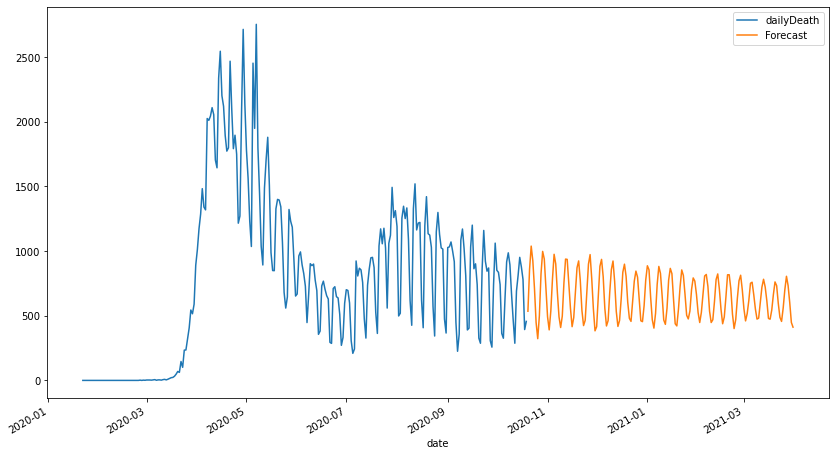

In [55]:
#Start: 10/20/20 
#End: 12/31/21

forecast1 = result2.predict(start = "2020-10-20",
                            end = '2021-03-31',                        
                            typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
df_copy['dailyDeath'].plot(figsize = (14, 8), legend = True) 
forecast1.plot(legend = True) 

In [56]:
fcast1 = result2.get_forecast(173)
print('Forecast:')
print(fcast1.predicted_mean)
print('Confidence intervals:')
print(fcast1.conf_int(alpha=0.1))

Forecast:
2020-10-10    752.099023
2020-10-11    439.002777
2020-10-12    336.648122
2020-10-13    541.313800
2020-10-14    845.396675
                 ...    
2021-03-27    804.642137
2021-03-28    732.660423
2021-03-29    600.796313
2021-03-30    447.406369
2021-03-31    411.465702
Freq: D, Name: predicted_mean, Length: 173, dtype: float64
Confidence intervals:
            lower dailyDeath  upper dailyDeath
2020-10-10        373.931438       1130.266608
2020-10-11          2.124417        875.881137
2020-10-12       -121.450101        794.746344
2020-10-13         53.216580       1029.411020
2020-10-14        312.583036       1378.210314
...                      ...               ...
2021-03-27      -5447.845483       7057.129757
2021-03-28      -5557.460907       7022.781754
2021-03-29      -5730.235722       6931.828347
2021-03-30      -5925.474172       6820.286911
2021-03-31      -6000.367151       6823.298555

[173 rows x 2 columns]


In [57]:
upper_1 = fcast1.conf_int(alpha=0.1).iloc[10:,1]
lower_1 = fcast1.conf_int(alpha=0.1).iloc[10:,0]

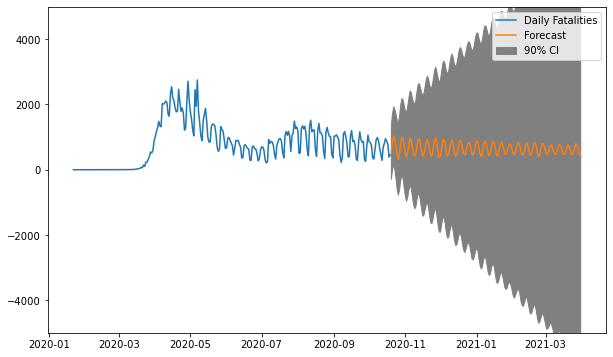

In [58]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast1.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast1
y3 = fcast1.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast1.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
plt.ylim(-5000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

### Scenario 2: Vaccine is not available until the end of 2021

- Start: 2020-10-20 
- End: 2021-06-30

<AxesSubplot:xlabel='date'>

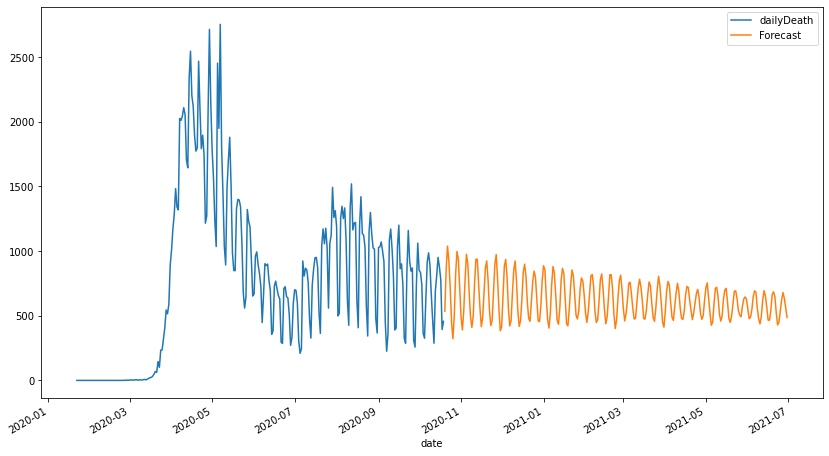

In [59]:
forecast2 = result2.predict(start = "2020-10-20",
                            end = '2021-06-30',                        
                            typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
df_copy['dailyDeath'].plot(figsize = (14, 8), legend = True) 
forecast2.plot(legend = True) 

In [60]:
fcast2 = result2.get_forecast(264)
print('Forecast:')
print(fcast2.predicted_mean)
print('Confidence intervals:')
print(fcast2.conf_int(alpha=0.1))

Forecast:
2020-10-10    752.099023
2020-10-11    439.002777
2020-10-12    336.648122
2020-10-13    541.313800
2020-10-14    845.396675
                 ...    
2021-06-26    621.867323
2021-06-27    679.054226
2021-06-28    634.545206
2021-06-29    558.772277
2021-06-30    486.204747
Freq: D, Name: predicted_mean, Length: 264, dtype: float64
Confidence intervals:
            lower dailyDeath  upper dailyDeath
2020-10-10        373.931438       1130.266608
2020-10-11          2.124417        875.881137
2020-10-12       -121.450101        794.746344
2020-10-13         53.216580       1029.411020
2020-10-14        312.583036       1378.210314
...                      ...               ...
2021-06-26      -9244.875790      10488.610436
2021-06-27      -9228.307401      10586.415852
2021-06-28      -9314.493979      10583.584391
2021-06-29      -9433.835505      10551.380058
2021-06-30      -9550.257830      10522.667323

[264 rows x 2 columns]


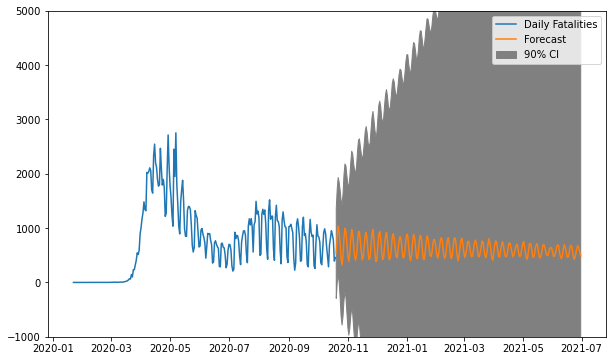

In [61]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast2.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast2
y3 = fcast2.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast2.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
plt.ylim(-1000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

### Scenario 3: Vaccine is not available until the end of 2021

<AxesSubplot:xlabel='date'>

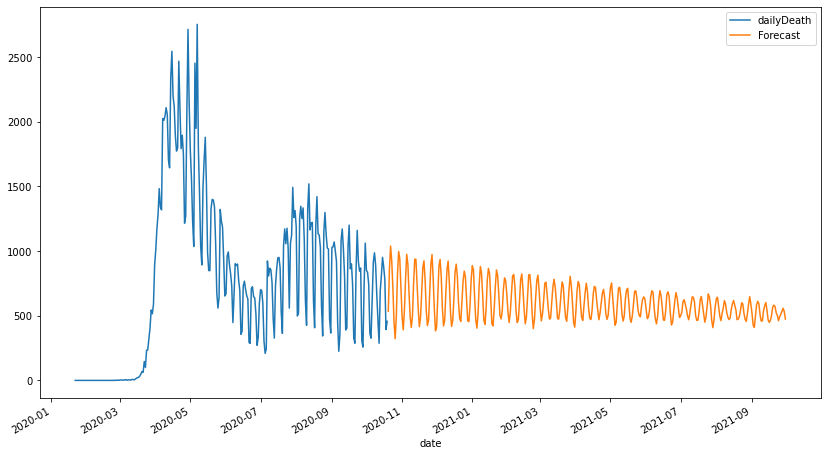

In [62]:
forecast3 = result2.predict(start = "2020-10-20",
                            end = '2021-09-30',                        
                            typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
df_copy['dailyDeath'].plot(figsize = (14, 8), legend = True) 
forecast3.plot(legend = True) 

In [63]:
fcast3 = result2.get_forecast(356)
print('Forecast:')
print(fcast3.predicted_mean)
print('Confidence intervals:')
print(fcast3.conf_int(alpha=0.1))

Forecast:
2020-10-10    752.099023
2020-10-11    439.002777
2020-10-12    336.648122
2020-10-13    541.313800
2020-10-14    845.396675
                 ...    
2021-09-26    511.272670
2021-09-27    533.178317
2021-09-28    557.599606
2021-09-29    532.814644
2021-09-30    474.212403
Freq: D, Name: predicted_mean, Length: 356, dtype: float64
Confidence intervals:
            lower dailyDeath  upper dailyDeath
2020-10-10        373.931438       1130.266608
2020-10-11          2.124417        875.881137
2020-10-12       -121.450101        794.746344
2020-10-13         53.216580       1029.411020
2020-10-14        312.583036       1378.210314
...                      ...               ...
2021-09-26     -13473.566157      14496.111496
2021-09-27     -13497.936065      14564.292699
2021-09-28     -13519.773690      14634.972901
2021-09-29     -13592.154527      14657.783816
2021-09-30     -13699.957808      14648.382615

[356 rows x 2 columns]


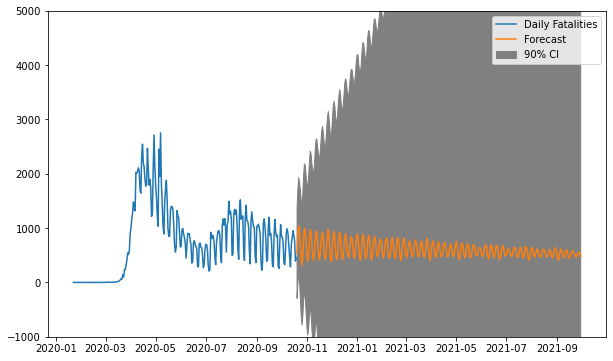

In [64]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast3.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast3
y3 = fcast3.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast3.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
plt.ylim(-1000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

### Scenario 4: Vaccine is not available until the end of 2021

- Start: 2020-10-20 
- End: 2021-12-31

<AxesSubplot:xlabel='date'>

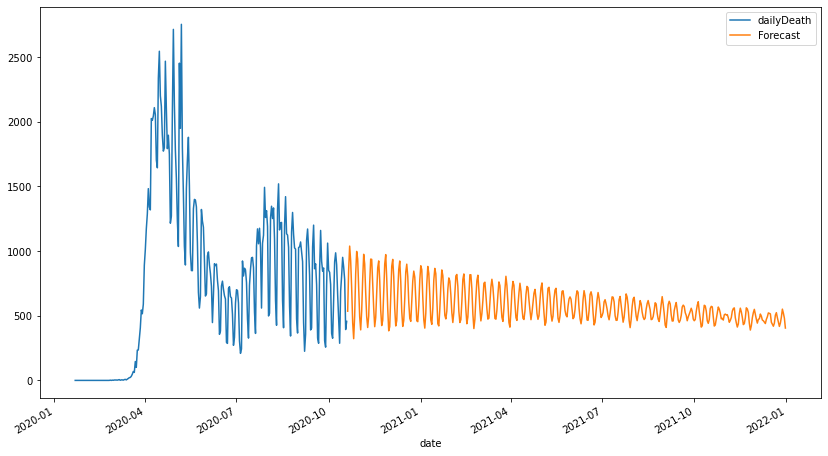

In [65]:
#Start: 10/20/20 
#End: 12/31/21

forecast4 = result2.predict(start = "2020-10-20",
                            end = '2021-12-31',                        
                            typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
df_copy['dailyDeath'].plot(figsize = (14, 8), legend = True) 
forecast4.plot(legend = True) 



### Estimate 90% Confidence Interval 

In [66]:
fcast4 = result2.get_forecast(448)
print('Forecast:')
print(fcast4.predicted_mean)
print('Confidence intervals:')
print(fcast4.conf_int(alpha=0.1))

Forecast:
2020-10-10    752.099023
2020-10-11    439.002777
2020-10-12    336.648122
2020-10-13    541.313800
2020-10-14    845.396675
                 ...    
2021-12-27    489.190564
2021-12-28    550.824447
2021-12-29    519.514308
2021-12-30    480.908554
2021-12-31    404.534480
Freq: D, Name: predicted_mean, Length: 448, dtype: float64
Confidence intervals:
            lower dailyDeath  upper dailyDeath
2020-10-10        373.931438       1130.266608
2020-10-11          2.124417        875.881137
2020-10-12       -121.450101        794.746344
2020-10-13         53.216580       1029.411020
2020-10-14        312.583036       1378.210314
...                      ...               ...
2021-12-27     -18041.768731      19020.149860
2021-12-28     -18032.728332      19134.377226
2021-12-29     -18115.782152      19154.810769
2021-12-30     -18206.950622      19168.767730
2021-12-31     -18336.454975      19145.523934

[448 rows x 2 columns]


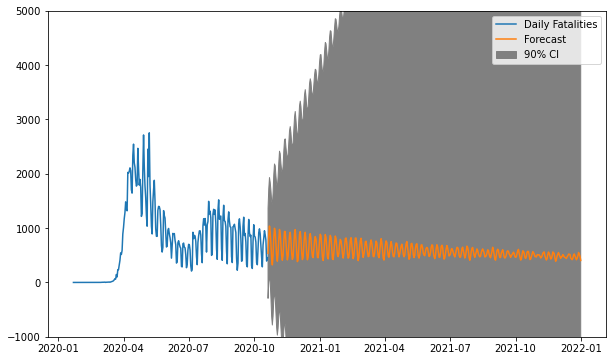

In [67]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast4.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast4
y3 = fcast4.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast4.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
plt.ylim(-1000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

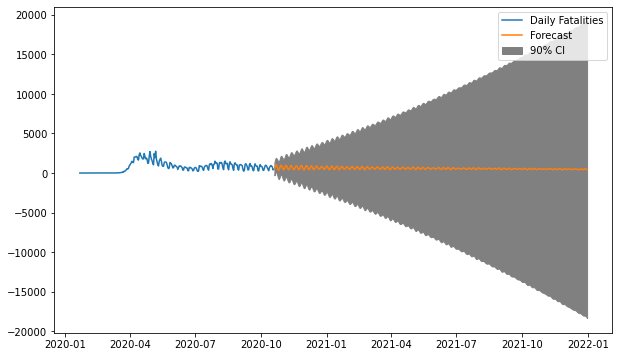

In [68]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast4.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast4
y3 = fcast4.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast4.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
#plt.ylim(-1000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

In [89]:
fatalities = {'Scenario 1':forecast1, 'Scenario 2':forecast2, 'Scenario 3':forecast3, 'Scenario 4':forecast4}

for result in fatalities:
    total_fatality = round(fatalities[result].sum(), 0)
    print('Total COVID-19 Fatalities in {0} is: {1:,}'.format(result, round(fatalities[result].sum())))

Total COVID-19 Fatalities in Scenario 1 is: 105,820
Total COVID-19 Fatalities in Scenario 2 is: 159,113
Total COVID-19 Fatalities in Scenario 3 is: 208,509
Total COVID-19 Fatalities in Scenario 4 is: 253,633
